In [ ]:
!pip install sentence_transformers spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from umap.umap_ import UMAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pickle
with open('/content/drive/MyDrive/Bertopic/Data/bs_emb.pkl', 'rb') as f:
  embeddings = pickle.load(f)
with open('/content/drive/MyDrive/Bertopic/Data/bs_sen.pkl', 'rb') as f:
  sentences = pickle.load(f)

In [ ]:
# Compute the term freqency dictionary
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Step 1: Create and fit the vectorizer
vectorizer = CountVectorizer(
    stop_words="english",
    min_df=2,
    ngram_range=(1, 2),
    token_pattern=r"(?u)\b\w{3,}\b"
)

X = vectorizer.fit_transform(sentences)

# Step 2: Get token names and their total frequencies
terms = vectorizer.get_feature_names_out()
frequencies = np.asarray(X.sum(axis=0)).flatten()

# Step 3: Create the dictionary
term_freq_dict = dict(zip(terms, frequencies))
total_term_freq = sum(frequencies)
# Example: print the top 10 most frequent terms
top_10 = sorted(term_freq_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print("🔝 Top 10 terms by frequency:")
for term, freq in top_10:
    print(f"{term:<20} : {freq}")


🔝 Top 10 terms by frequency:
trade                : 6751
union                : 5858
members              : 5559
work                 : 4551
labour               : 4476
time                 : 4048
general              : 3341
council              : 3278
workers              : 2803
conference           : 2462


In [ ]:
import numpy as np

def compute_gini(array_like):
    # Step 1: Convert to float64 and copy
    array = np.array(array_like, dtype=np.float64).copy()

    # Step 2: Handle empty or single-element input
    if len(array) <= 1:
        return 0.0  # Gini undefined or 0 for single item

    # Step 3: Handle negative values
    if np.amin(array) < 0:
        array -= np.min(array)

    # Step 4: Add small epsilon to avoid log(0) or division issues
    array += 1e-10

    # Step 5: Sort ascending
    array = np.sort(array)

    n = len(array)
    index = np.arange(1, n + 1)

    total = n * np.sum(array)
    top_sum = 2 * np.sum(index * array) / total
    gini = top_sum - (n + 1) / n

    # Optional: Clip result to [0, 1] range
    return np.clip(gini, 0.0, 1.0)

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from IPython.display import display
import gc

# ----------------------
# INIT: Load once
# ----------------------

# Assume these are already loaded from earlier steps
# sentences = ...  # List[str]
# embeddings = ...  # np.ndarray of shape (N, 768)

# Load once at start
model = SentenceTransformer('all-mpnet-base-v2')

# Precompute once
vectorizer_1gram = CountVectorizer(ngram_range=(1, 1), stop_words='english')
X_1gram = vectorizer_1gram.fit_transform(sentences)
word_freq = X_1gram.sum(axis=0).A1
vocab_1gram = vectorizer_1gram.get_feature_names_out()
top_1grams = [vocab_1gram[i] for i in word_freq.argsort()[::-1][:10]]

def extract_anchor_data(sentences, model, top_1grams, ngram_range, top_ngrams, min_len, anchor_count):
    vectorizer_ngram = CountVectorizer(ngram_range=ngram_range, stop_words='english', min_df=1)
    X_ngram = vectorizer_ngram.fit_transform(sentences)
    ngram_freq = X_ngram.sum(axis=0).A1
    vocab_ngram = vectorizer_ngram.get_feature_names_out()
    sorted_ngrams = [vocab_ngram[i] for i in ngram_freq.argsort()[::-1]]
    filtered_ngrams = sorted_ngrams[:top_ngrams]

    anchor_sentences = {}
    for ngram in filtered_ngrams:
        matches = [
            sent for sent in sentences
            if len(sent) >= min_len and ngram in sent.lower() and not contains_high_freq_word(sent, top_1grams)
        ]
        if matches:
            anchor_sentences[ngram] = matches[:anchor_count]

    anchor_vecs_by_ngram = {
        ngram: model.encode(sents, convert_to_numpy=True, normalize_embeddings=True)
        for ngram, sents in anchor_sentences.items()
    }

    return anchor_sentences, anchor_vecs_by_ngram



anchor_sentences, anchor_vecs_by_ngram = extract_anchor_data(
    sentences=sentences,
    model=model,
    top_1grams=top_1grams,
    ngram_range=(2, 3),
    top_ngrams=120,
    min_len=30,
    anchor_count=3
)


print("✅ INIT Complete: Model and high-frequency words loaded.")

✅ INIT Complete: Model and high-frequency words loaded.


In [ ]:
anchor_sentences, anchor_vecs_by_ngram = extract_anchor_data(
    sentences=sentences,
    model=model,
    top_1grams=top_1grams,
    ngram_range=(2, 3),
    top_ngrams=150,
    min_len=30,
    anchor_count=10
)

In [ ]:
print(anchor_sentences)

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from IPython.display import display
import gc
import spacy
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

def contains_high_freq_word(sentence, high_freq_words):
    return any(word in sentence.lower().split() for word in high_freq_words)

def run_semantopics(
    sentences,
    embeddings,
    model,
    top_1grams,
    ngram_range=(2, 3),
    top_ngrams=120,
    cos_sim_threshold=0.55,
    merge_threshold=0.6,
    min_len=30,
    anchor_count=3
):
    """
    Run topic modeling pipeline with customizable parameters.
    Designed to be called repeatedly without re-loading embeddings or model.
    """
    print("🔄 Running Semantopics iteration...")

    # Step 4: Build clusters based on similarity
    used_sentences = set()
    clusters = {}

    for ngram, anchors in anchor_sentences.items():
        cluster = set()

        for anchor_vec in anchor_vecs_by_ngram[ngram]:
            sim_scores = cosine_similarity([anchor_vec], embeddings)[0]
            for idx, score in enumerate(sim_scores):
                if score >= cos_sim_threshold and sentences[idx] not in used_sentences:
                    cluster.add(sentences[idx])
                    used_sentences.add(sentences[idx])

        if len(cluster) >= 10:
            clusters[ngram] = list(cluster)

    # Step 5: Merge similar topics
    best_merge = {}
    used = set()

    for n1, n2 in combinations(anchor_vecs_by_ngram.keys(), 2):
        if n1 in used or n2 in used:
            continue
        vecs1, vecs2 = anchor_vecs_by_ngram[n1], anchor_vecs_by_ngram[n2]
        max_sim = max(cosine_similarity([v1], [v2])[0][0] for v1 in vecs1 for v2 in vecs2)
        if max_sim >= merge_threshold:
            best_merge[n1] = n2
            used.update({n1, n2})

    merged_clusters = {}
    for n1, n2 in best_merge.items():
        label = f"{n1} + {n2}"
        merged_clusters[label] = list(set(clusters.get(n1, [])) | set(clusters.get(n2, [])))

    # Add unmerged clusters
    for ngram in clusters:
        if ngram not in used:
            merged_clusters[ngram] = clusters[ngram]

    # Step 6: c-TF-IDF and metrics
    docs, labels = [], []
    for ngram, sents in merged_clusters.items():
        docs.extend(sents)
        labels.extend([ngram] * len(sents))

    # Handle case where no topics are formed
    if not docs:
        print("No topics formed. Returning empty results.")
        return {
            "summary_table": pd.DataFrame(columns=['n_gram', 'sentence_count', 'top_words']),
            "gini": 0.0,
            "puv": 1.0,
            "assigned_count": 0,
            "topic_count": 0,
            "unassigned_count": len(sentences),
            "top_20": 0 # Or np.nan, depending on desired handling of no topics
        }


    vectorizer = CountVectorizer(stop_words='english', min_df=1)
    X = vectorizer.fit_transform(docs)
    tfidf = TfidfTransformer().fit(X)
    X_tfidf = tfidf.transform(X)
    feature_names = vectorizer.get_feature_names_out()

    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)
    tfidf_df['label'] = labels

    # Extract top words
    top_words = {}
    for ngram in tfidf_df['label'].unique():
        class_tfidf = tfidf_df[tfidf_df['label'] == ngram].drop('label', axis=1).mean()
        top_words[ngram] = list(class_tfidf.sort_values(ascending=False).head(10).index)

    count_table = pd.DataFrame([
        {'n_gram': k, 'sentence_count': len(v)} for k, v in merged_clusters.items()
    ]).sort_values('sentence_count', ascending=False)

    topic_keywords_df = pd.DataFrame([
        {'n_gram': k, 'top_words': ', '.join(v)} for k, v in top_words.items()
    ])

    summary_table = pd.merge(count_table, topic_keywords_df, on='n_gram')
    if len(summary_table) < 20:
      return None

    # Compute metrics

    def compute_puv(summary_table):
        # Handle case where there's only one topic or no topics
        if len(summary_table) <= 20:
            return 1.0, 0

        topic_terms = {
            idx: set(term.replace(" ", "_") for term in row['top_words'].split(", "))
            for idx, row in summary_table.head(20).iterrows()
        }
        ngram_value = 0
        words = []
        for idx, word_set in topic_terms.items():
          for word in word_set:
            words.append(word)
            if word in term_freq_dict:
                ngram_value += term_freq_dict[word]

        total_words = " ".join(words)
        doc = nlp(total_words)
        top_ngrams = [token.lemma_ for token in doc if not token.is_space]

        # 📊 Calculate PUV
        if top_ngrams:
            # ... calculate puv
            counts = Counter(top_ngrams).most_common()
            copied_ngrams = [ngram for ngram, freq in counts if freq > 1]
            puv = len(copied_ngrams) / len(top_ngrams)
        else:
            puv = 0.0

        return puv, ngram_value # <-- This is inside the else block, but the first return is not.



    gini_score = compute_gini(summary_table["sentence_count"].tolist())
    puv_score, ngram_value = compute_puv(summary_table)
    assigned_count = summary_table['sentence_count'].sum()

    # Only compute top_20 if there are at least 20 topics
    if len(summary_table) > 19:
        summary_table = summary_table.sort_values(by='sentence_count', ascending=False)
        top_20 = summary_table['sentence_count'].iloc[19]
    else:
        top_20 = 0 # Or np.nan, or some other indicator that there aren't 20 topics


    # Clean up memory after each run
    del X, tfidf, X_tfidf, tfidf_df, vectorizer
    gc.collect()

    return {
        "summary_table": summary_table,
        "gini": gini_score,
        "puv": puv_score,
        "assigned_count": assigned_count,
        "topic_count": len(summary_table),
        "unassigned_count": len(sentences) - assigned_count,
        "top_20": top_20,
        "ngram_value": round(ngram_value / total_term_freq, 2)
    }

In [ ]:
thresholds = np.arange(0.4, 0.5, 0.01)
results_list = []

for threshold in thresholds:
    print(f"\n🔁 Running with threshold={threshold}")
    results = run_semantopics(
        sentences=sentences,
        embeddings=embeddings,
        model=model,
        top_1grams=top_1grams,
        cos_sim_threshold=threshold
    )
    if results == None:
      continue

    results['threshold'] = threshold
    results_list.append(results)
    del results['summary_table']

    # Force cleanup between runs

    gc.collect()

# Convert to DataFrame for comparison
metrics_df_3 = pd.DataFrame(results_list)
print(metrics_df)


🔁 Running with threshold=0.4
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.41000000000000003
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.42000000000000004
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.43000000000000005
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.44000000000000006
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.45000000000000007
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.4600000000000001
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.4700000000000001
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.4800000000000001
🔄 Running Semantopics iteration...

🔁 Running with threshold=0.4900000000000001
🔄 Running Semantopics iteration...
       gini    puv  assigned_count  topic_count  unassigned_count  top_20  \
0  0.642764  0.175           87938           34             32943     925   
1  0.622814  0.180           84841           34         

In [ ]:
metrics_df = pd.DataFrame(results_list)
print(metrics_df[['threshold', 'gini', 'puv', 'topic_count', 'assigned_count']])
metrics_df['Percentage Appearance'] = metrics_df['assigned_count'] / len(sentences)*100


   threshold      gini    puv  topic_count  assigned_count
0       0.40  0.642764  0.175           34           87938
1       0.41  0.622814  0.180           34           84841
2       0.42  0.604490  0.180           34           81439
3       0.43  0.586574  0.185           34           77815
4       0.44  0.558859  0.180           33           73881
5       0.45  0.545350  0.210           33           69853
6       0.46  0.531371  0.210           33           65747
7       0.47  0.523708  0.210           33           61559
8       0.48  0.515490  0.205           33           57281
9       0.49  0.510692  0.210           33           52929


In [ ]:
metrics_df_2= pd.read_csv('/content/drive/MyDrive/Bertopic/Data/ngram2top_results.csv')

In [ ]:
metrics_df_3['Percentage Appearance'] = metrics_df_3['assigned_count'] / len(sentences)*100
filtered_df = metrics_df_3

summary_stats = filtered_df.agg(["mean", "std", "min", "max"]).transpose()

summary_stats= summary_stats.round(2)


# Rename columns for clarity
summary_stats.columns = ["Mean", "Standard Deviation", "Min", "Max"]

# Display the summary
summary_stats.head(10)

,Mean,Standard Deviation,Min,Max
gini,0.61,0.06,0.54,0.70
puv,0.19,0.02,0.16,0.22
assigned_count,79673.50,10447.38,62977.00,93668.00
topic_count,50.40,0.52,50.00,51.00
unassigned_count,41207.50,10447.38,27213.00,57904.00
top_20,1091.90,127.86,896.00,1290.00
ngram_value,0.38,0.02,0.35,0.40
threshold,0.44,0.03,0.40,0.49
Percentage Appearance,65.91,8.64,52.10,77.49


In [ ]:
filtered_df = metrics_df

summary_stats = filtered_df.agg(["mean", "std", "min", "max"]).transpose()

summary_stats= summary_stats.round(2)


# Rename columns for clarity
summary_stats.columns = ["Mean", "Standard Deviation", "Min", "Max"]

# Display the summary
summary_stats.head(10)

,Mean,Standard Deviation,Min,Max
gini,0.56,0.05,0.51,0.64
puv,0.19,0.02,0.18,0.21
assigned_count,71328.30,11897.35,52929.00,87938.00
topic_count,33.40,0.52,33.00,34.00
unassigned_count,49552.70,11897.35,32943.00,67952.00
top_20,986.50,110.21,772.00,1123.00
ngram_value,0.37,0.02,0.34,0.40
threshold,0.44,0.03,0.40,0.49
Percentage Appearance,59.01,9.84,43.79,72.75


In [ ]:
filtered_df = metrics_df_2.head(10)

summary_stats = filtered_df.agg(["mean", "std", "min", "max"]).transpose()

summary_stats= summary_stats.round(2)


# Rename columns for clarity
summary_stats.columns = ["Mean", "Standard Deviation", "Min", "Max"]

# Display the summary
summary_stats.head(10)

,Mean,Standard Deviation,Min,Max
Unnamed: 0,4.50,3.03,0.00,9.00
gini,0.53,0.02,0.52,0.57
puv,0.22,0.01,0.21,0.24
assigned_count,59108.30,12820.28,40073.00,77664.00
topic_count,48.80,0.92,48.00,50.00
unassigned_count,61772.70,12820.28,43217.00,80808.00
top_20,871.70,148.81,644.00,1090.00
ngram_value,0.36,0.02,0.33,0.39
threshold,0.44,0.03,0.40,0.49
Percentage Appearance,48.90,10.61,33.15,64.25


Spearman correlation = 0.40, p = 0.0169


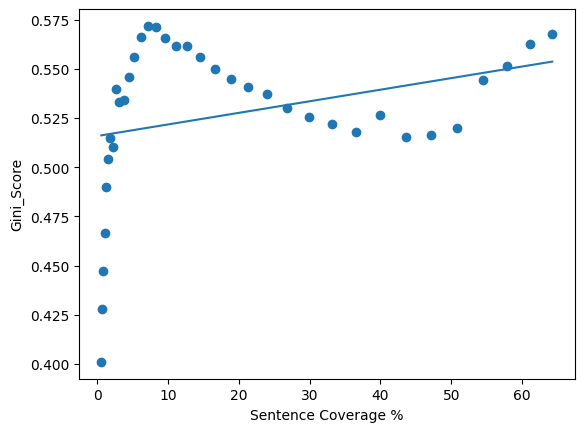

In [ ]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from scipy import stats
sort_metrics = metrics_df.head(36).sort_values(by='Percentage Appearance', ascending=True)
sort_metrics = sort_metrics[['Percentage Appearance', 'gini']]
sort_metrics = sort_metrics.drop_duplicates()
def myfunc(x):
  return slope * x + intercept


x = sort_metrics['Percentage Appearance']
y = sort_metrics['gini']

slope, intercept, r, p, std_err = stats.linregress(x, y)

mymodel = list(map(myfunc, x))
plt.xlabel("Sentence Coverage %")
plt.ylabel("Gini_Score")

plt.scatter(x, y)
plt.plot(x, mymodel)
rho, p_value = spearmanr(x, y)
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")

plt.show()

Spearman correlation = 1.00, p = 0.0000


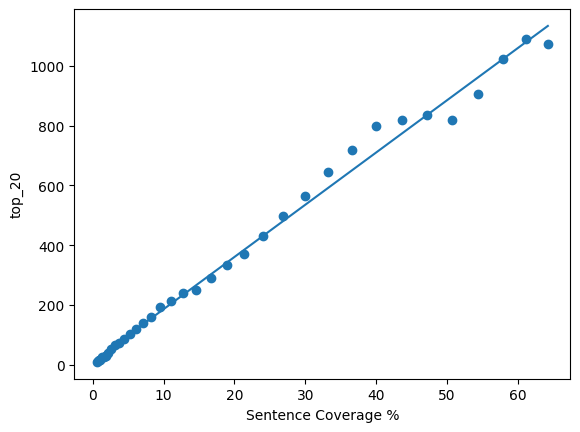

In [ ]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from scipy import stats
sort_metrics = metrics_df.head(36).sort_values(by='Percentage Appearance', ascending=True)
sort_metrics = sort_metrics[['Percentage Appearance', 'top_20']]
sort_metrics = sort_metrics.drop_duplicates()
def myfunc(x):
  return slope * x + intercept


x = sort_metrics['Percentage Appearance']
y = sort_metrics['top_20']

slope, intercept, r, p, std_err = stats.linregress(x, y)

mymodel = list(map(myfunc, x))
plt.xlabel("Sentence Coverage %")
plt.ylabel("top_20")

plt.scatter(x, y)
plt.plot(x, mymodel)
rho, p_value = spearmanr(x, y)
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")

plt.show()

Spearman correlation = 0.98, p = 0.0000


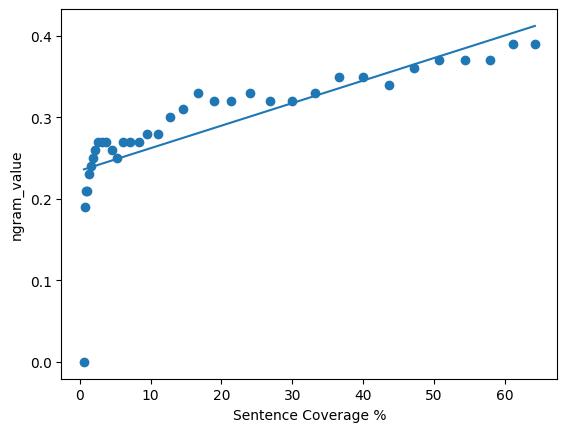

In [ ]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from scipy import stats
sort_metrics = metrics_df.head(36).sort_values(by='Percentage Appearance', ascending=True)
sort_metrics = sort_metrics[['Percentage Appearance', 'ngram_value']]
sort_metrics = sort_metrics.drop_duplicates()
def myfunc(x):
  return slope * x + intercept


x = sort_metrics['Percentage Appearance']
y = sort_metrics['ngram_value']

slope, intercept, r, p, std_err = stats.linregress(x, y)

mymodel = list(map(myfunc, x))
plt.xlabel("Sentence Coverage %")
plt.ylabel("ngram_value")

plt.scatter(x, y)
plt.plot(x, mymodel)
rho, p_value = spearmanr(x, y)
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")

plt.show()

Spearman correlation = 0.60, p = 0.0001


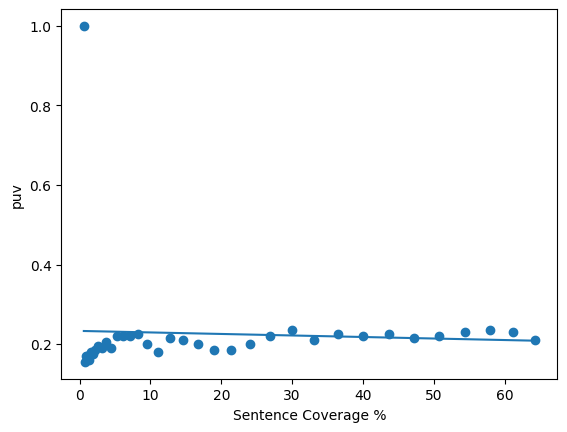

In [ ]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from scipy import stats
sort_metrics = metrics_df.head(36).sort_values(by='Percentage Appearance', ascending=True)
sort_metrics = sort_metrics[['Percentage Appearance', 'puv']]
sort_metrics = sort_metrics.drop_duplicates()
def myfunc(x):
  return slope * x + intercept


x = sort_metrics['Percentage Appearance']
y = sort_metrics['puv']

slope, intercept, r, p, std_err = stats.linregress(x, y)

mymodel = list(map(myfunc, x))
plt.xlabel("Sentence Coverage %")
plt.ylabel("puv")

plt.scatter(x, y)
plt.plot(x, mymodel)
rho, p_value = spearmanr(x, y)
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")

plt.show()